# 07 Milestone Project 1: 🍔👁 Food Vision Big
In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model which beat the original results of the Food101 paper with only 10% of the data.

## Check GPU

In [17]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-075f79f1-98c3-577b-3902-248a036d93a6)


Bu defter için farklı bir şey yapacağız. Karma hassas eğitim kullanacağız. Karma hassasiyet eğitimi, TensorFlow 2.4.0'da tanıtıldı (bu yazı yazıldığı sırada çok yeni bir özellik). Karma hassasiyet eğitimi ne yapar? Karma duyarlıklı eğitim, model eğitimini hızlandırmak için tek duyarlıklı (float32) ve yarı kesinlikli (float16) veri türlerinin bir kombinasyonunu kullanır (modern GPU'larda 3 kata kadar). Bunun hakkında daha sonra konuşacağız, ancak bu arada daha fazla ayrıntı için TensorFlow'un karma kesinlik hakkındaki belgelerini okuyabilirsiniz. Şimdilik, karma kesinlikli eğitim kullanmak istiyorsak ilerlemeden önce, Google Colab örneğimizi destekleyen GPU'nun (Google Colab kullanıyorsanız) uyumlu olduğundan emin olmamız gerekiyor. Karma hassasiyet eğitiminin işe yaraması için, 7,0 işlem uyumluluk puanına sahip bir GPU'ya erişmeniz gerekir. Google Colab, çeşitli GPU türleri sunar. Ancak, bazıları karışık hassasiyet eğitimi ile uyumlu değildir. Bu nedenle, Google Colab'de karma kesinlik eğitimine erişiminiz olduğundan emin olmak için şu adreste GPU bilgi işlem yeteneği puanınızı kontrol edebilirsiniz:

## Get helper functions

In [18]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [19]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

Tensorflow datasetini kulanarak 101 sinifli yemek görselerini yükleyeceğiz

Önceki not defterlerinde, yiyecek resimlerimizi (Food101 veri kümesinden) Google Storage'dan indirmiştik. Ve bu, kendi veri kümeleriniz üzerinde çalışıyorsanız kullanacağınız tipik bir iş akışıdır. Ancak, veri kümelerini TensorFlow ile kullanıma hazır hale getirmenin başka bir yolu var. Makine öğrenimi dünyasındaki en popüler veri kümelerinin çoğuna (genellikle karşılaştırmalı değerlendirme olarak atıfta bulunulur ve kullanılır), bunlara TensorFlow Veri Kümeleri (TFDS) aracılığıyla erişebilirsiniz. TensorFlow Veri Kümeleri nedir? Hazır ve kullanıma hazır makine öğrenimi veri kümeleri için bir yer. TensorFlow Veri Kümelerini neden kullanmalıyım? Halihazırda Tensors'ta bulunan verileri yükleyin Yerleşik veri kümeleri üzerinde Pratik yapın Farklı veri yükleme teknikleriyle denemeler yapın (bu not defterinde kullanacağımız gibi) Yeni TensorFlow özelliklerini hızlı bir şekilde deneyin (karma hassaslık eğitimi gibi) Neden TensorFlow Veri Kümeleri kullanmıyorsunuz? Veri kümeleri statiktir (gerçek dünyadaki veri kümelerinizin yapacağı gibi değişmezler) Özel probleminiz için uygun olmayabilir (ancak deney yapmak için harikadır) TensorFlow Veri Kümelerini kullanmaya başlamak için onu tfds takma adı altında içe aktarabiliriz.

In [20]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

TensorFlow Veri Kümelerindeki tüm kullanılabilir veri kümelerini bulmak için list_builders() yöntemini kullanabilirsiniz. Bunu yaptıktan sonra, peşinde olduğumuz ("yemek101") olup olmadığını kontrol edebiliriz.

In [21]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset} in Tensorflow Daatasets:{target_dataset in datasets_list}")# belirtiğimiz datasetin tensorflow içerisinde var olup olmadığını kontrol ettik

'food101 in Tensorflow Daatasets:True


In [22]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data)

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteW7YI4H/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

* The shape of our input data (image tensors)

* The datatype of our input data

* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)

* Do the labels match up with the class names?

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor,label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 38
  Class name (str form): fish_and_chips
        


In [11]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[182, 225, 242],
        [180, 223, 240],
        [179, 220, 238],
        ...,
        [157, 202, 221],
        [157, 204, 222],
        [158, 205, 223]],

       [[179, 222, 239],
        [178, 221, 238],
        [178, 219, 237],
        ...,
        [162, 207, 226],
        [162, 209, 227],
        [163, 210, 228]],

       [[178, 221, 238],
        [176, 219, 236],
        [177, 218, 236],
        ...,
        [168, 213, 232],
        [168, 215, 233],
        [167, 214, 232]],

       ...,

       [[149,  97,  39],
        [159, 109,  50],
        [156, 110,  50],
        ...,
        [108, 143, 149],
        [108, 143, 149],
        [107, 142, 148]],

       [[168, 117,  60],
        [172, 123,  65],
        [170, 125,  66],
        ...,
        [106, 141, 147],
        [106, 141, 147],
        [105, 140, 146]],

       [[183, 132,  75],
        [182, 133,  75],
        [179, 134,  75],
        ...,
        [106, 141, 14

In [12]:
import tensorflow as tf
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

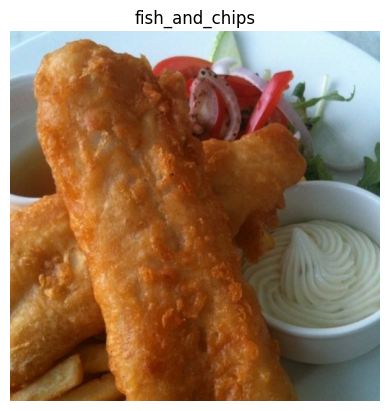

In [13]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Not: tf.keras.applications.efficientnet'teki (biz ne kullanacağız) önceden eğitilmiş EfficientNetBX modellerinde yerleşik olarak yeniden ölçeklendirme vardır. Ancak diğer birçok model mimarisi için verilerinizi yeniden ölçeklendirmek isteyeceksiniz (örneğin, değerlerini 0 ve 1 arasında alın). Bu, "preprocess_img()" işlevinizin içine (aşağıdaki gibi) veya modelinizin içine bir tf.keras.layers.Rescaling katmanı olarak dahil edilebilir.

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[182 225 242]
  [180 223 240]
  [179 220 238]
  ...
  [157 202 221]
  [157 204 222]
  [158 205 223]]

 [[179 222 239]
  [178 221 238]
  [178 219 237]
  ...
  [162 207 226]
  [162 209 227]
  [163 210 228]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[179.19897 222.19897 239.19897]
  [178.02551 219.02551 237.02551]
  [184.21428 220.78572 240.     ]
  ...
  [164.71938 206.28062 226.     ]
  [159.61736 204.61736 223.61736]
  [160.57146 207.57146 225.57146]]

 [[177.31123 220.31123 237.31123]
  [177.86224 218.86224 236.86224]
  [184.0153  221.0153  240.0153 ]
  ...
  [163.12755 203.53067 223.72963]
  [169.72447 213.00002 232.00002]
  [168.5714  214.37758 232.97449]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


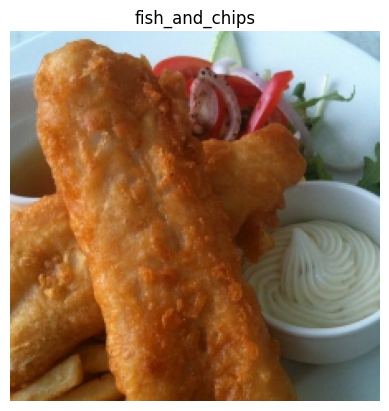

In [16]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

Verilerimizi modellemeden önce, onu gruplara dönüştürmemiz gerekir. Neden? Çünkü yığınlar üzerinde bilgi işlem bellek açısından verimlidir. 101.000 görüntü tensörü ve etiketinden (eğitim ve test birleştirilmiş) verilerimizi 32 görüntü ve etiket çifti grubuna dönüştürüyoruz, böylece GPU'muzun belleğine sığmasını sağlıyoruz. Bunu etkili bir şekilde yapmak için, tf.data API'sinden bir dizi yöntemden yararlanacağız. 📖 Kaynak: Verileri mümkün olan en yüksek performansla yüklemek için tf.data API ile Daha İyi performans konulu TensorFlow belgelerine bakın.


* map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)

* shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)

* batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)

* prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
********************************************************************************
* map() - önceden tanımlanmış bir işlevi bir hedef veri kümesine eşler (örn. preprocess_img() görüntü tensörlerimize)

* shuffle() - bir hedef veri kümesinin öğelerini tampon_boyutu kadar rasgele karıştırır (ideal olarak, tampon_boyutu veri kümesinin boyutuna eşittir, ancak bunun bellek üzerinde etkileri olabilir)

* toplu iş () - bir hedef veri kümesinin öğelerini toplu işlere dönüştürür (batch_size parametresi tarafından tanımlanan boyut)

* prefetch() - diğer veri grupları hesaplanırken sonraki veri gruplarını hazırlar (veri yükleme hızını artırır ancak belleğe mal olur)
Ekstra: cache() - öğeleri bir hedef veri kümesinde önbelleğe alır (sonrası için saklar), yükleme süresinden tasarruf sağlar (yalnızca veri kümeniz belleğe sığacak kadar küçükse çalışır, standart Colab örneklerinde yalnızca 12 GB bellek bulunur)





In [23]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>